In [1]:
import warnings; warnings.simplefilter('ignore')

In [40]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ,QuantumRegister,ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from iqx import *

# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

In [28]:
#Grover Iterations subcircuit
def get_grover_iteration_subcircuit(reg_size):
    fit_qreg = QuantumRegister(reg_size+1,"fqreg")
    oracle_ws = QuantumRegister(1,"ows")
    grover_circ = QuantumCircuit(fit_qreg,oracle_ws,name ="U$_s$")

    grover_circ.h(fit_qreg)
    grover_circ.x(fit_qreg)

    grover_circ.h(oracle_ws[0])

    grover_circ.mct(list(range(reg_size+1)), oracle_ws[0])  # multi-controlled-toffoli

    grover_circ.h(oracle_ws[0])


    grover_circ.x(fit_qreg)
    grover_circ.h(fit_qreg)
    grover_circ.h(oracle_ws)

    grover_circ.draw() 
    return grover_circ.to_instruction()

In [29]:
def init_circuit(qc,qubits):
    for q in qubits:
        qc.h(q)
    return qc

In [59]:
n = 3 #third qubit is the workspace
qreg = QuantumRegister(2,"qreg")
ows = QuantumRegister(1,"ws")
creg = ClassicalRegister(2,"creg")
qc = QuantumCircuit(qreg,ows,creg)

qc = init_circuit(qc,[i for i in range(0,n)])

In [60]:
#Oracle

qc.h(2)
qc.x(0)
#qc.x(1)
qc.ccx(0,1,2)
qc.x(0)
#qc.x(1)
qc.h(2)

qc.barrier()
qc.draw()

┌───┐┌───┐     ┌───┐ ░ 
qreg_0: ┤ H ├┤ X ├──■──┤ X ├─░─
        ├───┤└───┘  │  └───┘ ░ 
qreg_1: ┤ H ├───────■────────░─
        ├───┤┌───┐┌─┴─┐┌───┐ ░ 
  ws_0: ┤ H ├┤ H ├┤ X ├┤ H ├─░─
        └───┘└───┘└───┘└───┘ ░ 
creg: 2/═══════════════════════

In [61]:
# qc.h([i for i in range(0,n-1)])
# qc.x([i for i in range(0,n-1)])

# qc.cz(0,1)

# qc.x([i for i in range(0,n-1)])
# qc.barrier()
# qc.h([i for i in range(0,n)])
# qc.draw()

In [62]:
grover_instr = get_grover_iteration_subcircuit(1)
qc.append(grover_instr,[qreg[0],qreg[1],ows[0]])
qc.draw()

┌───┐┌───┐     ┌───┐ ░ ┌────────┐
qreg_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤0       ├
        ├───┤└───┘  │  └───┘ ░ │        │
qreg_1: ┤ H ├───────■────────░─┤1 U$_s$ ├
        ├───┤┌───┐┌─┴─┐┌───┐ ░ │        │
  ws_0: ┤ H ├┤ H ├┤ X ├┤ H ├─░─┤2       ├
        └───┘└───┘└───┘└───┘ ░ └────────┘
creg: 2/═════════════════════════════════

In [63]:
decomposed_circ = qc.decompose() # Does not modify original circuit
decomposed_circ.draw()

┌─────────┐┌───────────┐                                            »
qreg_0: ┤ U2(0,π) ├┤ U3(π,0,π) ├───────────────────■─────────────────────■──»
        ├─────────┤└───────────┘                   │             ┌───┐   │  »
qreg_1: ┤ U2(0,π) ├────────────────────■───────────┼─────────■───┤ T ├───┼──»
        ├─────────┤ ┌─────────┐ ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐»
  ws_0: ┤ U2(0,π) ├─┤ U2(0,π) ├─┤ H ├┤ X ├┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├»
        └─────────┘ └─────────┘ └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘»
creg: 2/════════════════════════════════════════════════════════════════════»
                                                                            »
«              ┌───┐            ┌───────────┐ ░ ┌───┐┌───┐     ┌───┐┌───┐
«qreg_0: ──■───┤ T ├──────■─────┤ U3(π,0,π) ├─░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«        ┌─┴─┐┌┴───┴┐   ┌─┴─┐   └───────────┘ ░ ├───┤├───┤  │  ├───┤├───┤
«qreg_1: ┤ X ├┤ TDG ├───┤ X ├─────────────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├
«        ├───┤└┬───┬┘┌──┴───┴──┐              ░ ├───┤└───┘┌─┴─┐├───┤├───┤
«  ws_0: ┤ T ├─┤ H ├─┤ U2(0,π) ├──────────────░─┤ H ├─────┤ X ├┤ H ├┤ H ├
«        └───┘ └───┘ └─────────┘              ░ └───┘     └───┘└───┘└───┘
«creg: 2/════════════════════════════════════════════════════════════════
«

In [64]:
qc.measure(qreg,creg)
qc.draw()

┌───┐┌───┐     ┌───┐ ░ ┌────────┐┌─┐   
qreg_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤0       ├┤M├───
        ├───┤└───┘  │  └───┘ ░ │        │└╥┘┌─┐
qreg_1: ┤ H ├───────■────────░─┤1 U$_s$ ├─╫─┤M├
        ├───┤┌───┐┌─┴─┐┌───┐ ░ │        │ ║ └╥┘
  ws_0: ┤ H ├┤ H ├┤ X ├┤ H ├─░─┤2       ├─╫──╫─
        └───┘└───┘└───┘└───┘ ░ └────────┘ ║  ║ 
creg: 2/══════════════════════════════════╩══╩═
                                          0  1

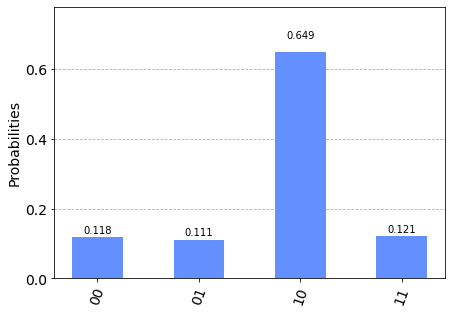

In [65]:

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)